## Model of polychotomous (anti)conformity with $n$ role models and $m$ variants

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [2]:
def rounding(frqs):
    """
    The input to this function is frqs, a list of frequencies that all must be between 0 and 1 
    and sum to 1. The output is the list of frequencies without rounding error. 
    """    
    frqs_in_bounds = []
    for frq in frqs: # Ensure that all frequencies are in [0,1] 
        if frq < 0: frq = 0
        elif frq > 1: frq = 1
        frqs_in_bounds.append(frq)
    
    valid_frqs = []
    normalizer = np.sum(frqs_in_bounds)
    for frq in frqs_in_bounds: # Ensure that all frequencies sum to 1 
        frq /= normalizer 
        valid_frqs.append(frq)
    return valid_frqs 

In [3]:
def get_states(n, m):
    """
    This function takes in n, the number of role models, and m, the number
    of phenotypes, and outputs all possible role model states.
    Credit to: Mark Tolonen, 2019, “Generate all possible lists of length N that sum to S in Python.”
    https://stackoverflow.com/questions/7748442/generate-all-possible-lists-of-length-n-that-sum-to-s-in-python
    """
    if m == 1:
        yield (n,)
    else:
        for elem in range(n + 1):
            for state in get_states(n - elem, m - 1):
                yield (elem,) + state

#### Modified function p_prime where d(x) is very close to its lower bound

In [4]:
def p_prime(n, p_vec):
    """
    This function takes in n, the number of role models, and p_vec = (p1, p2, ..., pm),
    the initial population frequencies of variants A1, A2, ..., Am, respectively.
    It outputs the vector p_prime_vec = (p1', p2', ..., pm'). 
    """
    pr = 10 # Precision, which will be used later in the function
    p_vec = rounding(p_vec) 
    m = len(p_vec) 
    states = list(get_states(n, m))  # Get all possible role model states
    previous_states = {} # This dictionary will store previous, symmetrical role model states 
    
    p_prime_vec = [None]*m
    for j in range(m):
        p_prime_vec[j] = p_vec[j] # This is the first term in Eq. 4 
    
    for x_vec in states: # For each role model state 
        # Make a unique string for each symmetrical role model configuration (to be used later)
        x_vec_copy = list(x_vec).copy()
        x_vec_copy.sort()
        x_str = str(x_vec_copy[0])
        for a in range(1,len(x_vec_copy)):
            x_str = x_str + str(x_vec_copy[a]) 

        # Find the bounds on d(x)
        x_subset = [j for j in x_vec if j != 0]
        x_subset.sort(reverse=True)
        x_avg = n / len(x_subset)

        index = 0
        denom_high = 0
        if x_subset[index] > round(x_avg, pr): 
            while x_subset[index] > round(x_avg, pr):
                denom_high += x_subset[index]
                index += 1
        else: # All elements are equal, and they equal the average
            denom_high = 0

        index = len(x_subset) - 1
        denom_low = 0
        if x_subset[index] < round(x_avg, pr):
            while x_subset[index] < round(x_avg, pr):
                denom_low += 1 / (x_subset[index])
                index -= 1
        else: # All elements are equal, and they equal the average
            denom_low = 0 
        
        if x_str in previous_states:
            d = previous_states[x_str] # To preserve symmetry      
        else: 
            if round(denom_high,pr) == 0 or round(denom_low,pr) == 0:
                d = 0
            else:
                d_min = -1 * denom_high
                d_max = ((n / x_subset[0]) - 1) * denom_high
                
                # Only this part of the code is different:
                d = d_min + 1e-7
               
        previous_states[x_str] = float(d)
        d = float(d)
        
        numerator = math.factorial(n)
        denominator = 1
        for l in range(len(x_vec)): 
            numerator *= p_vec[l] ** (x_vec[l])
            denominator *= math.factorial(x_vec[l])
            
        for l in range(m):
            x_l = x_vec[l]
            if round(d,pr) == 0:
                p_prime_vec[l] = p_prime_vec[l]
            if (round(x_l, pr) == 0) or (round(x_l, pr) == n) or (round(x_l, pr) == round(x_avg, pr)):
                p_prime_vec[l] = p_prime_vec[l]
            elif x_l > x_avg:
                conform = (x_l / denom_high) * (d / n)
                p_prime_vec[l] = float(p_prime_vec[l] + (conform * numerator / denominator))
            elif x_l < x_avg:
                conform = - (1 / x_l) * (1 / denom_low) * (d / n)
                p_prime_vec[l] = float(p_prime_vec[l] + (conform * numerator / denominator))
            
    return rounding(p_prime_vec)

In [5]:
def all_recursions(n, init_p, gen):
    """
    Inputs are n, the number of role models; init_p = (p1, p2, ..., pm), 
    the initial population frequencies of variants A1, A2, ..., Am, respectively; 
    and gen, the number of generations that the simulation will run for. 
    """
    p_vec = rounding(init_p) 
    m = len(init_p)
    all_p_over_time = [[None]]*m
    for j in range(m):
        all_p_over_time[j] = [p_vec[j]] 
    
    for i in range(gen): 
        p_vec = p_prime(n, p_vec)
        for j in range(m):
            all_p_over_time[j].append(p_vec[j])
            
    return all_p_over_time 

#### $n=4$ role models and $m=3$ variants

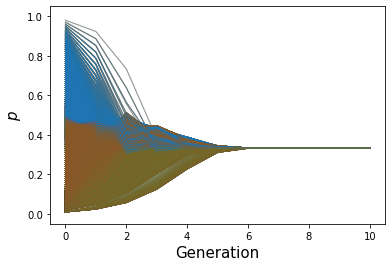

In [6]:
n = 4
plt.ylim([-0.05, 1.05]) 
plt.ylabel(r'$p$', fontsize=15)
plt.xlabel('Generation', fontsize=15)
total = 100
gen = 10
pr = 12 # Precision 
for i in range(total+1):
    for j in range(total+1):
        a = i/total
        b = j/total
        init_p = rounding([a,b,1-a-b])
        if round(init_p[0],pr)>0 and round(init_p[1],pr)>0 and round(init_p[2],pr)>0:
            result = all_recursions(n, init_p, gen)
            plt.plot(result[0], "tab:blue", linewidth=1, alpha=0.3)
            plt.plot(result[1], "tab:red", linewidth=1, alpha=0.3)
            plt.plot(result[2], "tab:green", linewidth=1, alpha=0.3)
                        

#### $n=4$ role models and $m=4$ variants

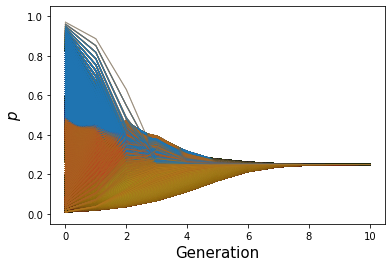

In [7]:
n = 4
plt.ylim([-0.05, 1.05]) 
plt.ylabel(r'$p$', fontsize=15)
plt.xlabel('Generation', fontsize=15)
total = 100
gen = 10
pr = 12 # Precision 
for i in range(total+1):
    for j in range(total+1):
        for k in range(total+1):
            a = i/total
            b = j/total
            c = k/total
            init_p = rounding([a,b,c,1-a-b-c])
            if round(init_p[0],pr)>0 and round(init_p[1],pr)>0 and round(init_p[2],pr)>0 and round(init_p[3],pr):
                result = all_recursions(n, init_p, gen)
                plt.plot(result[0], "tab:blue", linewidth=1, alpha=0.3)
                plt.plot(result[1], "tab:red", linewidth=1, alpha=0.3)
                plt.plot(result[2], "tab:green", linewidth=1, alpha=0.3)
                plt.plot(result[3], "tab:orange", linewidth=1, alpha=0.3)



#### $n=5$ role models and $m=3$ variants

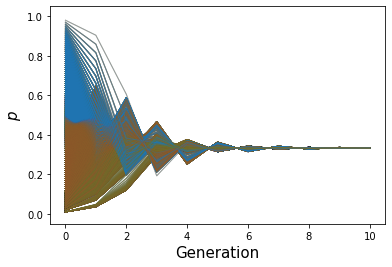

In [8]:
n = 5
plt.ylim([-0.05, 1.05]) 
plt.ylabel(r'$p$', fontsize=15)
plt.xlabel('Generation', fontsize=15)
total = 100
gen = 10
pr = 12 # Precision 
for i in range(total+1):
    for j in range(total+1):
        a = i/total
        b = j/total
        init_p = rounding([a,b,1-a-b])
        if round(init_p[0],pr)>0 and round(init_p[1],pr)>0 and round(init_p[2],pr)>0:
            result = all_recursions(n, init_p, gen)
            plt.plot(result[0], "tab:blue", linewidth=1, alpha=0.3)
            plt.plot(result[1], "tab:red", linewidth=1, alpha=0.3)
            plt.plot(result[2], "tab:green", linewidth=1, alpha=0.3)
            

#### $n=5$ role models and $m=4$ variants

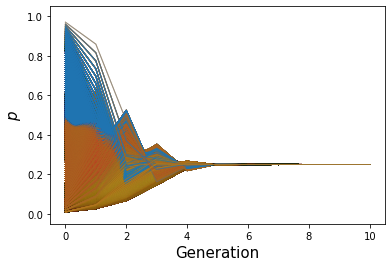

In [9]:
n = 5
plt.ylim([-0.05, 1.05]) 
plt.ylabel(r'$p$', fontsize=15)
plt.xlabel('Generation', fontsize=15)
total = 100
gen = 10
pr = 12 # Precision 
for i in range(total+1):
    for j in range(total+1):
        for k in range(total+1):
            a = i/total
            b = j/total
            c = k/total
            init_p = rounding([a,b,c,1-a-b-c])
            if round(init_p[0],pr)>0 and round(init_p[1],pr)>0 and round(init_p[2],pr)>0 and round(init_p[3],pr):
                result = all_recursions(n, init_p, gen)
                plt.plot(result[0], "tab:blue", linewidth=1, alpha=0.3)
                plt.plot(result[1], "tab:red", linewidth=1, alpha=0.3)
                plt.plot(result[2], "tab:green", linewidth=1, alpha=0.3)
                plt.plot(result[3], "tab:orange", linewidth=1, alpha=0.3)

